## Sagnac Frequency - Compare Beat of Rings

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
from functions.interpolate_nan import __interpolate_nan

In [4]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [5]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{str(dat)[:4]}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")
    if df.empty:
        print(" -> empty dataframe!")
        return df

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [6]:
def __smooth(y, npts):

    from numpy import ones, convolve, hanning, nan

    win = hanning(npts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

In [7]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [8]:
def __get_mlti_intervals(mlti_times):

    from obspy import UTCDateTime
    from numpy import array

    t1, t2 = [], []
    for k,_t in enumerate(mlti_times):

        _t = UTCDateTime(_t)

        if k == 0:
            _tlast = _t
            t1.append(_t)

        if _t -_tlast > 60:
            t2.append(_tlast)
            t1.append(_t)

        _tlast = _t

    t2.append(_t)

    return array(t1), array(t2)

In [9]:
def __load_mlti(tbeg, tend, ring, path_to_archive):

    from obspy import UTCDateTime
    from pandas import read_csv

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    year = tbeg.year

    rings = {"U":"03", "Z":"01", "V":"02", "W":"04"}

    path_to_mlti = path_to_archive+f"romy_archive/{year}/BW/CROMY/{year}_romy_{rings[ring]}_mlti.log"

    mlti = read_csv(path_to_mlti, names=["time_utc","Action","ERROR"])

    mlti = mlti[(mlti.time_utc > tbeg) & (mlti.time_utc < tend)]

    return mlti

In [10]:
def __mlti_intervals_to_NaN(df_in, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where

    df_in['fj_nan'] = df_in['fj']

    for t1, t2 in zip(mlti_t1, mlti_t2):

        ## trim times to minutes and add t_offset_sec
        tt1, tt2 = str(t1-t_offset_sec)[:16], str(t2+t_offset_sec)[:16]

        ## replace data during mlti times with NaN values
        df_in['fj_nan'] = where((df_in.times_utc > str(tt1)) & (df_in.times_utc < str(tt2)), nan, df_in['fj_nan'])

    return df_in

## Configurations

In [39]:
config = {}

config['tbeg'] = UTCDateTime("2023-12-18 00:00")
config['tend'] = UTCDateTime("2024-01-06 00:00")


## path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [40]:
beatU = __load_beat(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_beat(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_beat(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


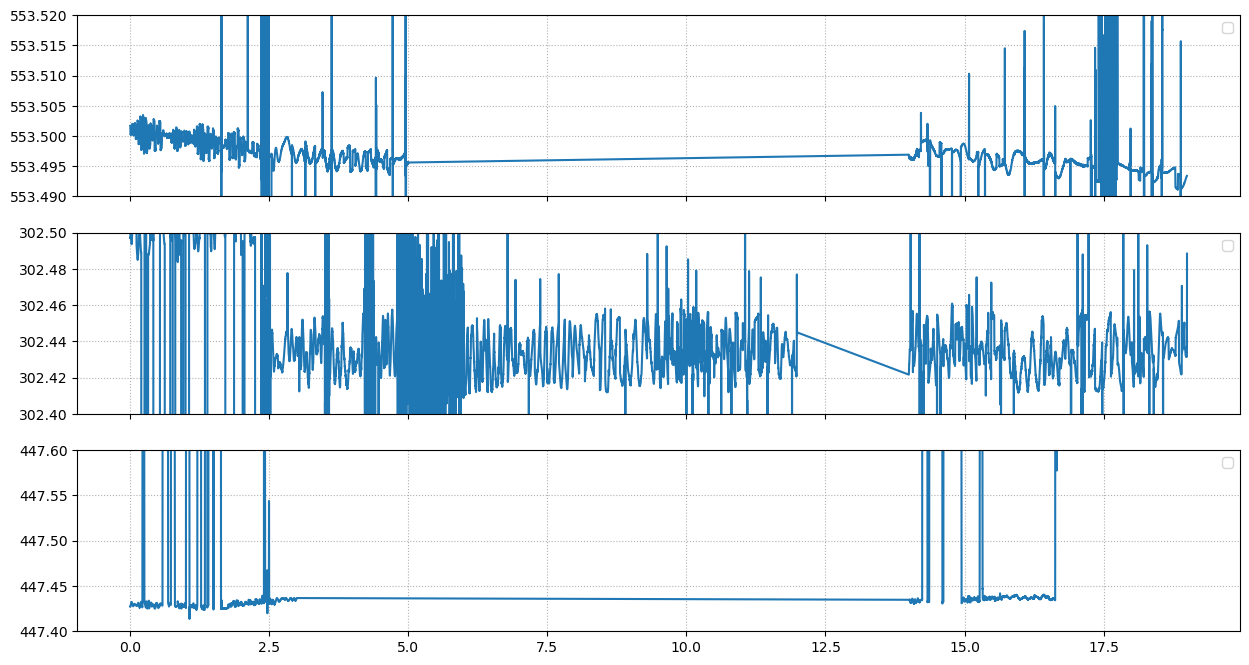

In [41]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj)
    ax[0].set_ylim(553.49, 553.52)
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj)
    ax[1].set_ylim(302.4, 302.5)
    ax[1].ticklabel_format(useOffset=False)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj)
    ax[2].set_ylim(447.4, 447.6)
    ax[2].ticklabel_format(useOffset=False)

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


## Remove breakdown periods

In [14]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    beatU['fj'] = np.where((beatU.times_utc > t1) & (beatU.times_utc < t2), np.nan, beatU['fj'])

beatU['fj'] = np.nan_to_num(beatU['fj'], nan=np.nanmedian(beatU['fj']))

In [15]:
times = [("2023-12-07T00:10", "2023-12-08T18:00:30")]

for t1, t2 in times:
    beatZ['fj'] = np.where((beatZ.times_utc > t1) & (beatZ.times_utc < t2), np.nan, beatZ['fj'])

beatZ['fj'] = np.nan_to_num(beatZ['fj'], nan=np.nanmedian(beatZ['fj']))

## Remove MLTI times

In [16]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [17]:
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

In [18]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

In [19]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [20]:
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [21]:
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

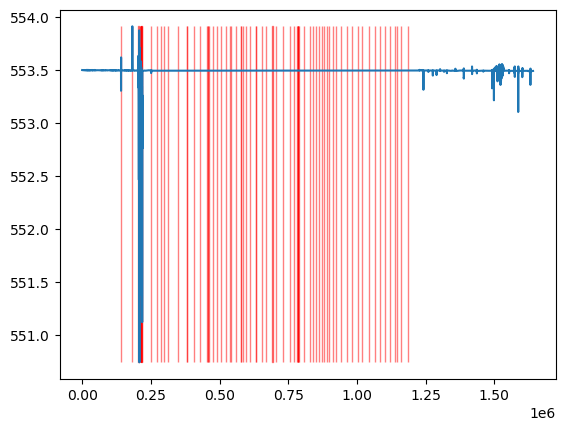

In [22]:
# df, mlti, mlti_t1, mlti_t2  = beatU, mltiU, mltiU_t1, mltiU_t2
# df, mlti, mlti_t1, mlti_t2  = beatV, mltiV, mltiV_t1, mltiV_t2
df, mlti, mlti_t1, mlti_t2  = beatZ, mltiZ, mltiZ_t1, mltiZ_t2


time_axis = df.times_utc_sec-df.times_utc_sec.iloc[0]
plt.plot(time_axis, df.fj, zorder=2)

# for m in mlti.time_utc:
#     plt.axvline((UTCDateTime(m)-config['tbeg'])/86400, color="red", zorder=0, alpha=0.5)

miny, maxy = min(df.fj), max(df.fj)
for t1, t2 in zip(mlti_t1, mlti_t2):
    plt.fill_betweenx([miny, maxy], t1-config['tbeg'], t2-config['tbeg'], color="red", alpha=0.5)

In [24]:
# i1, i2 = 8880, 17876
# print(beatZ.times_utc.iloc[i1], beatZ.times_utc.iloc[i2])
# plt.plot(beatZ.times_utc_sec.iloc[i1:i2], beatZ.fj.iloc[i1:i2])

In [25]:
beatU = __mlti_intervals_to_NaN(beatU, mltiU_t1, mltiU_t2, t_offset_sec=180)
beatV = __mlti_intervals_to_NaN(beatV, mltiV_t1, mltiV_t2, t_offset_sec=180)
beatZ = __mlti_intervals_to_NaN(beatZ, mltiZ_t1, mltiZ_t2, t_offset_sec=180)

## Interpolate NaN values

In [26]:
beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))
beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

## Smoothing

In [27]:
beatU['fj_smooth'] = __smooth(beatU.fj_inter, 300)
beatV['fj_smooth'] = __smooth(beatV.fj_inter, 300)
beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, 300)

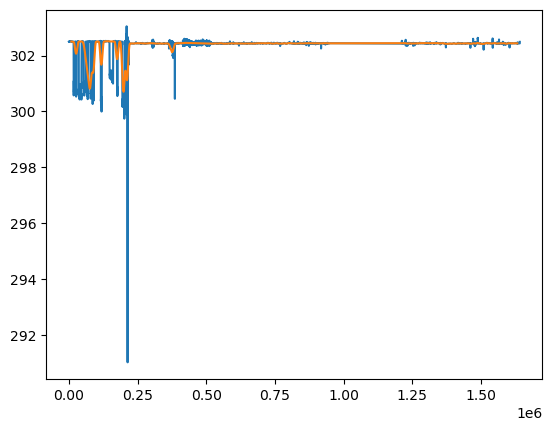

In [28]:
time_axis = beatU.times_utc_sec-beatU.times_utc_sec.iloc[0]
plt.plot(time_axis, beatU.fj, zorder=2)
plt.plot(time_axis, beatU.fj_smooth, zorder=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


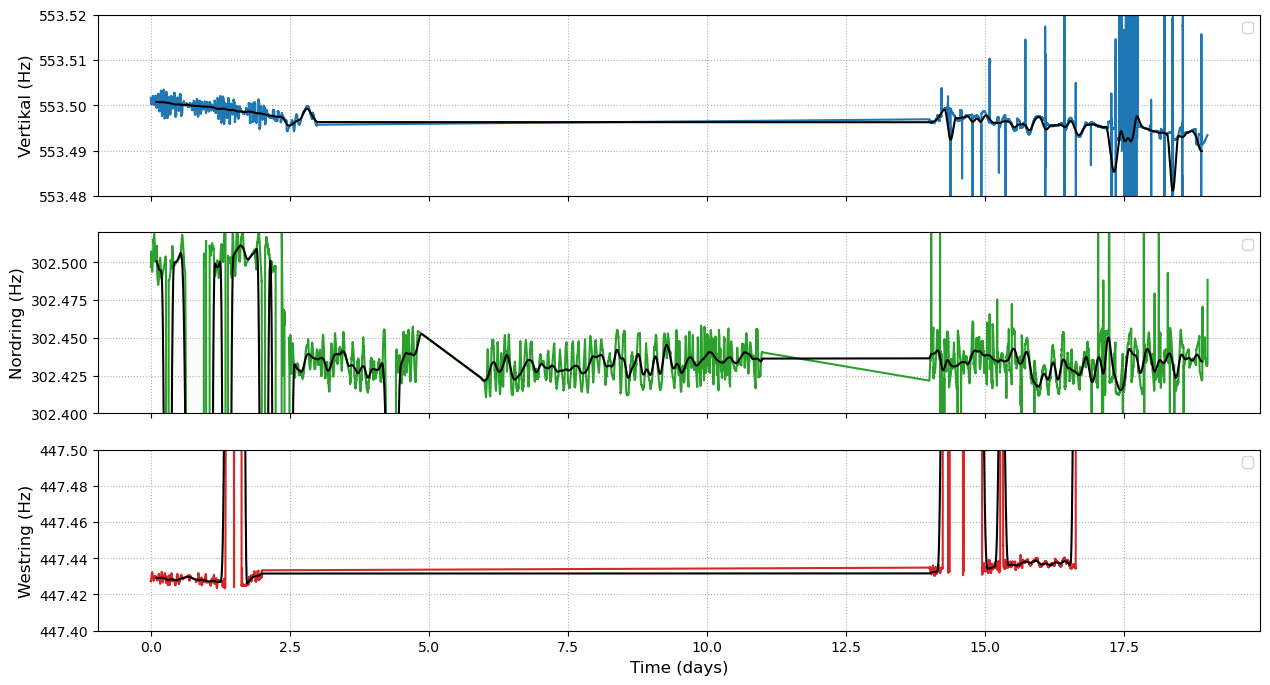

In [29]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    time_scaling = 1/86400

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_inter, color="tab:blue")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth, color="k")
    ax[0].set_ylim(553.48, 553.52)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Vertikal (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_inter, color="tab:green")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth, color="k")
    ax[1].set_ylim(302.4, 302.52)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Nordring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_inter, color="tab:red")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth, color="k")
    ax[2].set_ylim(447.4, 447.5)
    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Westring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[2].set_xlabel("Time (days)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();


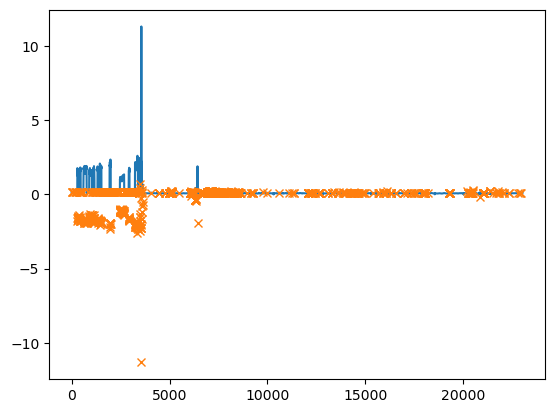

In [30]:
from scipy.signal import find_peaks

dat = np.array(beatU.fj) - np.mean(beatU.fj)

peaks, _ = find_peaks(abs(dat), height=0.1)

np.diff(peaks)

plt.plot(abs(dat))

plt.plot(peaks, dat[peaks], "x")

plt.show()

In [31]:
def __smooth(y, npts):

    from numpy import ones, convolve, hanning, nan

    win = hanning(npts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    y_smooth[:npts//2] = nan
    y_smooth[-npts//2:] = nan
    return y_smooth

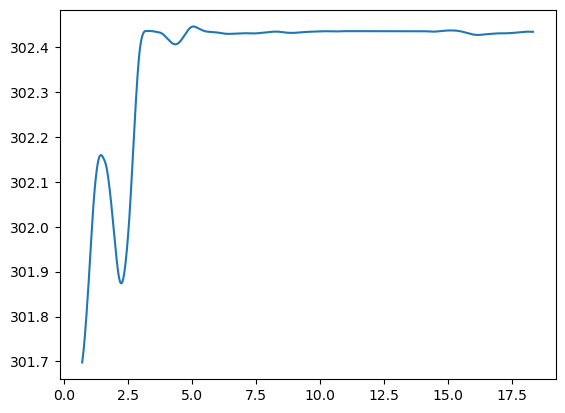

In [32]:
Udata = beatU.fj.fillna(np.nanmedian(beatU.fj))

dat = __smooth(Udata, 2000)
plt.plot(beatU.times_utc_sec/86400, dat)

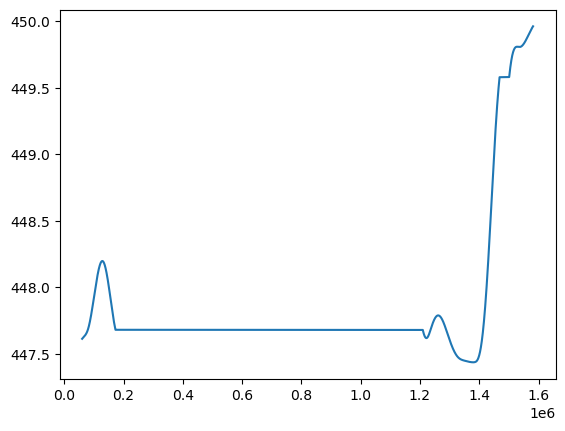

In [33]:
Vdata = beatV.fj.fillna(np.median(beatV.fj))

dat = __smooth(Vdata, 2000)
plt.plot(beatV.times_utc_sec, dat)

In [34]:
# beatU['fj'] = beatU['fj'].where(lambda x: x >= 302.4, np.nan)

ValueError: x and y must have same first dimension, but have shapes (23040,) and (9540,)

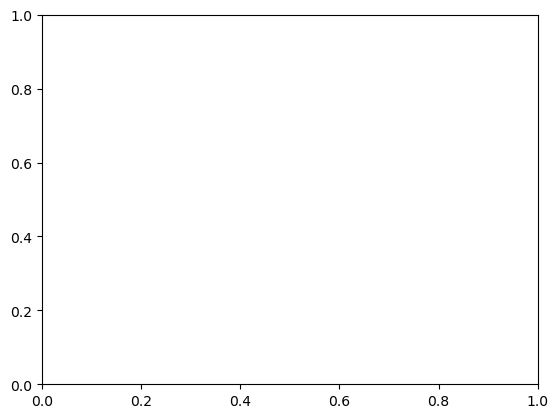

In [35]:
plt.plot(beatU.times_utc_sec, dat)

In [ ]:
tr_beatU = Trace()
tr_beatU.data = np.array(beatU.fj)
tr_beatU.stats.delta = 60
tr_beatU.stats.starttime = UTCDateTime(str(beatU.times_utc.iloc[0]))
tr_beatU.plot();

tr_beatV = Trace()
tr_beatV.data = np.array(beatV.fj)
tr_beatV.stats.delta = 60
tr_beatV.stats.starttime = UTCDateTime(str(beatV.times_utc.iloc[0]))
tr_beatV.plot();

tr_beatZ = Trace()
tr_beatZ.data = np.array(beatZ.fj)
tr_beatZ.stats.delta = 60
tr_beatZ.stats.starttime = UTCDateTime(str(beatZ.times_utc.iloc[0]))
tr_beatZ.plot();


f1 = 1/(1*3600)

tr_beatU.detrend("simple")
tr_beatU.taper(0.01)
tr_beatU.filter("lowpass", freq=f1, corners=4, zerophase=True)
tr_beatU.plot();

tr_beatV.detrend("simple")
tr_beatV.taper(0.01)
tr_beatV.filter("lowpass", freq=f1, corners=4, zerophase=True)
tr_beatV.plot();

tr_beatZ.detrend("simple")
tr_beatZ.taper(0.01)
tr_beatZ.filter("lowpass", freq=f1, corners=4, zerophase=True)
tr_beatZ.plot();


In [ ]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(tr_beatZ.times()*time_scaling, tr_beatZ.data)

    ax[1].plot(tr_beatU.times()*time_scaling, tr_beatU.data)
    # ax[1].set_ylim(-0.05, 0.05)

    ax[2].plot(tr_beatV.times()*time_scaling, tr_beatV.data)
    # ax[2].set_ylim(-0.05, 0.05)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();


In [ ]:
f1 = 1/(13*3600)
f2 = 1/(11*3600)

f1 = 1/(25*3600)
f2 = 1/(23*3600)


print(f1, f2)

tr = Trace()
tr.data = dat
tr.stats.delta = 60
tr.stats.starttime = bs.time1[0]
tr.plot();
print(tr)

tr.plot();

tr = tr.detrend("demean").detrend("linear")
tr.plot();

tr = tr.taper(0.1)
tr.plot();

# tr.filter("lowpass", freq=f2, corners=2, zerophase=True)
tr = tr.filter("bandpass", freqmin=f1, freqmax=f2, corners=2, zerophase=True)
tr.plot();

fs_tilt_lp = tr.data

In [ ]:
from statsmodels.tsa.seasonal import MSTL
from pandas import to_datetime

In [ ]:
dat = DataFrame(beatU, columns=["times_utc","fj"])
dat = dat.set_index("times_utc")
dat.index = to_datetime(dat.index)

In [ ]:
dat

In [36]:
model = MSTL(dat, periods=(2, 12, 24), stl_kwargs={"seasonal_deg": 0})

res = model.fit()

NameError: name 'MSTL' is not defined

In [37]:
res.plot();

NameError: name 'res' is not defined

In [38]:

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dat, model='additive', period=24*14)

result.plot()

plt.show()

ValueError: This function does not handle missing values